In [58]:
# Import Libraries
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import numpy as np
import scipy as sp
from numpy.linalg import pinv
from numpy.random import randint, normal
from networkx.algorithms.clique import find_cliques, enumerate_all_cliques
from networkx.algorithms.matching import maximal_matching
from networkx.algorithms.operators.unary import complement
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.linalg.algebraicconnectivity import algebraic_connectivity
from scipy import stats
import itertools as it
from collections import Counter

In [96]:
# Adjust plot size
plt.rcParams["figure.figsize"] = (15, 5)

# Block RK Functions
These are our block RK functions with different varations, but they all return the same items

In [2]:
# Standard Block RK
# x_list allows us to track evolution of x and its individual components (for "collapse" graph?)
# Takes in c: initial vector, b: Ax=b (column of zeros), A: incidence matrix, and sol: solution to Ax=b
# Also takes in list of lists (Blocks) where each block is a list of rows within the incidence matrix corresponding to
# specific subgraphs and N, number of maximum iterations
# Returns: final value of x, list of x over iterations, and error over iterations

def blockRK(A, sol, b, blocks, N, c):
    k = len(blocks)http://localhost:8888/notebooks/AC-Kaczmarz/Block%20RK%20Methods%20-%20Working%20Copy.ipynb#Block-RK-Functions
    x = c
    x_list = [x]
    errors = []
    for j in range (1, N+1):
        i = randint(k);
        x = x + np.linalg.pinv(A[blocks[i],:])@(b[blocks[i]] - A[blocks[i],:]@x)
        errors.append(np.linalg.norm(x-sol))
        x_list.append(np.asarray(x))
    return x, x_list, errors

In [3]:
# Corrupted block RK with random link failure (RLF)
# Fails on each block randomly from a normal distribution
# Independent but not identical probability of failure
# Accepts fixed failure probability (Bernoulli)

def blockRK_RLF(A, sol, b, blocks, N, c, p=0.3):
    k = len(blocks)
    x = c
    x_list = [x]
    errors = []
    for j in range (1, N+1):
        r = stats.bernoulli.rvs(p, size = 1);
        i = randint(k)
        if r[0] == 1:
            x = x + np.linalg.pinv(A[blocks[i],:])@(b[blocks[i]] - A[blocks[i],:]@x)
        errors.append(np.linalg.norm(x-sol))
        x_list.append(x)
    return x, x_list, errors

In [4]:
# Corrupted block RK with one-off random additive noise (Gaussian)
# Adds a Gaussian noise vector to b at first

def blockRK_AGN(A, sol, b, blocks, N, c, s=0.05, m=0):
    k = len(blocks)
    x = c
    errors = []
    x_list = [x]
    err = normal(m, s, b.shape)
    b = b + err
    for j in range (1, N+1):
        x = x + np.linalg.pinv(A[blocks[i],:])@(b[blocks[i]] - A[blocks[i],:]@x) + err
    errors.append(np.linalg.norm(x-sol))
    x_list.append(x)
    return x, errors

In [5]:
# Corrupted block RK with two modes of failure: ONE-OFF additive gaussian noise and
# random link failure

def blockRK_cor(A, sol, b, blocks, N, c, p=0.3, m=0, s=0.1):
    k = len(blocks)
    x = c
    errors = []
    x_list = []
    err = normal(m, s, b.shape)
    b = b + err
    for j in range (1, N+1):
        r = stats.bernoulli.rvs(p, size = 1);
        i = randint(k)
        if r[0] == 1:
            x = x + np.linalg.pinv(A[blocks[i],:])@(b[blocks[i]] - A[blocks[i],:]@x)
            errors.append(np.linalg.norm(x-sol))
    return x, x_list, errors

# Helper Functions
These are various helper functions for use; some of them are wrapped and will not be used standalone

In [6]:
# Helper Functions for Size

# NOT TO BE USED STANDALONE
def trivial(x):
    if len(x)<=1: #MAYBE CHANGE THIS?
        return False
    return True

In [7]:
# Helper Functions for Size

# NOT TO BE USED STANDALONE
def max_size(x, n):
    if len(x)>n:
        return False
    return True

In [8]:
# Removes all trivial subgraphs and subgraphs that are too big according to some specified maximum size
# Takes in a list of lists (list of subgraphs by nodes e.g. [1, 2] is the subgraph with the nodes 1, 2; [2, 4, 5] is the
# subgraph with nodes 2, 4 and 5)
# If no maximum size is given, only removes trivial cliques

def remove_trivial_subgraphs(sgs, n=0):
    fil_sg = list(filter(trivial, sgs))
    if n == 0:
        return fil_sg
    else:
        fil_sg = list(filter(max_size, fil_sg))
        return fil_sg

In [9]:
# Helper functions for grabbing row indices for subgraphs

# Converts sets of edges into row indices in the incidence matrix
def find_subgraph_from_edges(A,edges):
    edge_indices = []
    for edge in edges:
        for i in range(A.shape[0]):
            if A[i,edge[0]] != 0 and A[i,edge[1]] != 0:
                edge_indices.append(i)
    if len(edges) != len(edge_indices):
        print("Did not find all edges of subgraph in incidence matrix.")
    return edge_indices

In [10]:
# Helper functions for grabbing row indices for subgraphs
# This is problematic!! 
# need to turn list of pnts into edges
# use this for enumerate_all_cliques!
def find_subgraph_from_pnts(A,pnts):
    edge_indices = []
    for j in range(len(pnts)-1):
        for i in range(A.shape[0]):
            if A[i, pnts[j]] != 0 and A[i, pnts[j+1]]:
                edge_indices.append(i)
            if A[i, pnts[0]] != 0 and A[i, pnts[len(pnts)-1]] !=0:
                if i not in edge_indices:
                    edge_indices.append(i)
    if (len(pnts)) != len(edge_indices):
        print("Did not find all edges of subgraph in incidence matrix.")
    return edge_indices

In [11]:
# Given a list of points, grabs blocks and makes a list

def blocks_pnts(A, subgraphs):
    blocks = []
    for subgraph in subgraphs:
        blocks.append(find_subgraph_from_pnts(A, subgraph))
    return blocks

In [12]:
# Turns a list of points into a list of edges
def edges_from_pnts(subgraph):
    edges = []
    n = len(subgraph)
    for i in range(n-1):
        edges.append((subgraph[i], subgraph[i+1]))
    return edges

In [13]:
def blocks_edge(A, subgraphs):
    blocks = []
    for subgraph in subgraphs:
        blocks.append(find_subgraph_from_edges(A, subgraph))
    return blocks

## Corollary 1.3 Helper Functions

In [15]:
def eigenvalue(blk, A):
    blks = [A[i] for i in blk]
    mat = np.concatenate(blks, axis=0)
    eigs, vec = np.linalg.eig(mat*mat.transpose())
    # We want minimum non-zero eigenvalue and maximum non-zero eigenvalue
    mineig = np.min(eigs[np.nonzero(eigs)])
    maxeig = np.max(eigs[np.nonzero(eigs)])
    return mineig, maxeig

In [16]:
def alpha(blks, A):
    alpha = 0
    beta = 100000
    for blk in blks:
        if eigenvalue(blk, A)[0] < mineigs:
            alpha = eigenvalue(blk, A)[0]
        if eigenvalue(blk, A)[1] > maxeigs:
            beta = eigenvalue(blk, A)[1]
    return alpha, beta 

In [88]:
def rR(blks):
    #Counter(it.chain.from_iterable(map(set, blks))
# OR 
    counts = Counter(x for xs in blks for x in set(xs))
    R = counts.most_common()[0][1]
    r = counts.most_common()[-1][1]
    return r, R

In [18]:
def findM(blks):
    M = np.max([len(blk) for blk in blks])
    return M

In [60]:
# Corollary 1.3

# Independent edge sets
def rate_ies(G, blks):
    k = len(blks)
    bound = 1-rR(blks)[0]*algebraic_connectivity(G)/(2*k)
    return bound

# Paths
def rate_paths(G, blks):
    k = len(blks)
    bound = 1-rR(blks)[0]*algebraic_connectivity(G)//(4*k)
    return bound

# Cliques
def rate_cliques(G, blks):
    k = len(blks)
    bound = 1-rR(blks)[0]*algebraic_connectivity(G)/(4*k)
    return bound

# Arbitrary Blocks
def rate_arbi(G, blks):
    k = len(blks)
    M = findM(blks)
    bound = 1-rR(blks)[0]*algebraic_connectivity(G)/(M*k)
    return bound


## Graphing Helper Functions
These graph the output of a specific Block RK function

In [104]:
# n is number of nodes in graph! 
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
def collapse_plt(x_list, n, N, x_bar):
    x_axis = x_list.copy()
    for i in range(N+1):
        x_axis[i] = np.concatenate(x_axis[i])
        # np.append(x_axis[i], x_bar)
    for i in range (n):
        plt.plot(range(N+1), [x_axis[f][i] for f in range(N+1)])

In [87]:
def error_plt(errors, G, blks, sol, rate='arbi'):
    if rate == 'cliques':
        r = rate_cliques(G, blks)
    elif rate == 'ies':
        r = rate_ies(G,blks)
    elif rate == 'path':
        r = rate_paths(G, blks)
    elif rate == 'arbi':
        r = rate_arbi(G, blks)
    else:
        print('rate not supported, using arbitrary blk rate')
        r = rate_arbi(G, blks)
    bound = [r*c for c in errors]
    plt.semilogy(range(np.shape(errors)[0]),errors)
    #plt.semilogy(range(np.shape(bound)[0]), bound)

## Conditioning Specific Helper Functions
These wrap the above functions and apply them to specific conditions: e.g. cliques

In [23]:
# Provides a non-overlapping independent edge cover over a graph G
# Returns a list of list of edges 
def independent_edge_sets(G):
    # use maximal_matching!
    # Take a copy of G 
    H = G.copy()
    ies = []
    while len(H.edges())> 0: 
        ieset = maximal_matching(H)
        ies.append(ieset)
        H.remove_edges_from(ieset)
    return ies

In [24]:
def blocks_from_ies(G, A):
    subs = independent_edge_sets(G)
    blks = blocks_edge(A, subs)
    return blks

In [25]:
# Grabs subgraphs that correspond to cliques within a graph
# Input: Incidence matrix, graph

def blocks_from_cliques(G, A):
    cliques = list(enumerate_all_cliques(G))
    # fill_cliques = remove_trivial_subgraphs(cliques)
    clique_edge = []
    for clique in cliques:
        clique_edge.append(edges_from_pnts(clique))
    blks = blocks_edge(clique_edge)
    return blks

In [26]:
# helper functions for path selection
# path with no restrictions except length
# if a path terminates before the length, the short path is returned 
def find_path(G, r, l):
    path = [r]
    path.append(find_edge(G, r, -1))
    while len(path)<l:
        path.append(find_edge(G, path[len(path)-1], path[len(path)-2]))
    return path
        
def find_edge(G, r, e=-1):
    # e = previous node (so we don't choose consecutive repeating edges)
    if e != -1: # no previous node
        neighbors = [n for n in G.neighbors(r)]
        if len(neighbors)==0:
            print("no neighbors found, isolated point")
            return
        else:
            a = neighbors[np.random.randint(0, len(neighbors)-1)]
            return a
    else:
        neighbors = [n for n in G.neighbors(r)]
        neighbors = list(filter(lambda x: x!=e, neighbors))
        if len(neighbors)<=1:
            print("no neighbors found, path terminates here")
            return
        else: 
            a = neighbors[np.random.randint(0, len(neighbors)-1)]
            return a

def path_blk(A, G, r, l):
    path = find_path(G, r, l)
    blk = find_subgraph_from_edges(A, edges_from_pnts(path))
    return blk

In [27]:
# block RK for paths
# since paths are selected randomly at each step, returns an additional paths which is the list of blks chosen
def blockRK_path(A, G, sol, b, N, c, l):
    x = c
    x_list = [x]
    errors = [np.linalg.norm(x-sol)]
    paths = []
    for j in range(1, N+1):
        r = randint(len(G.nodes))
        blk = path_blk(A, G, r, l)
        paths.append(blk)
        x = x + np.linalg.pinv(A[blk,:])@(b[blk] - A[blk,:]@x)
        errors.append(np.linalg.norm(x-sol))
        x_list.append(np.asarray(x))
    return paths, x, x_list, errors

# Experiments
Run all experiments here

### Graph and Problem Set-Up

In [112]:
# Initialize Graph
n = 50
m = 1000
p = 0.4
G = erdos_renyi_graph(n, p)

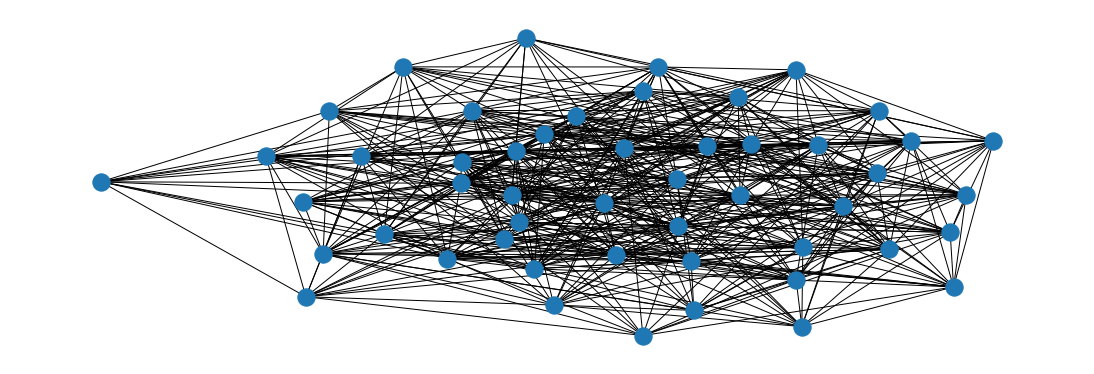

In [113]:
# Draw graph
nx.draw(G)
plt.show()

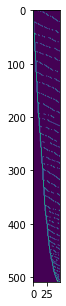

In [114]:
# Initialize Incidence Matrix
A = nx.linalg.graphmatrix.incidence_matrix(G)
A = sp.sparse.csr_matrix.todense(A).transpose()
plt.imshow(A)  # their incidence matrix is binary, we need to convert one of the ones to a -1

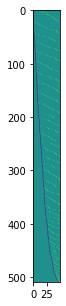

In [115]:
for i in range(np.shape(A)[0]):
    negindex = np.where(A[i,:] == 1)
    A[i,negindex[1][0]] = -1
plt.imshow(A)

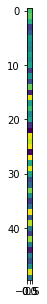

In [116]:
# Fix x, b
# Secret initial vector x
x = np.random.rand(n,1)
plt.imshow(x)
# Zero Vector b
b = np.zeros((m,1))

In [117]:
# Find mean of x
xbar = np.mean(x)
# Create solution vector (vector with just xbar as values)
sol = np.full((n,1), xbar)
sol

array([[0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.53415561],
       [0.534

In [37]:
# Initialize ER Graph
# n is the same as above


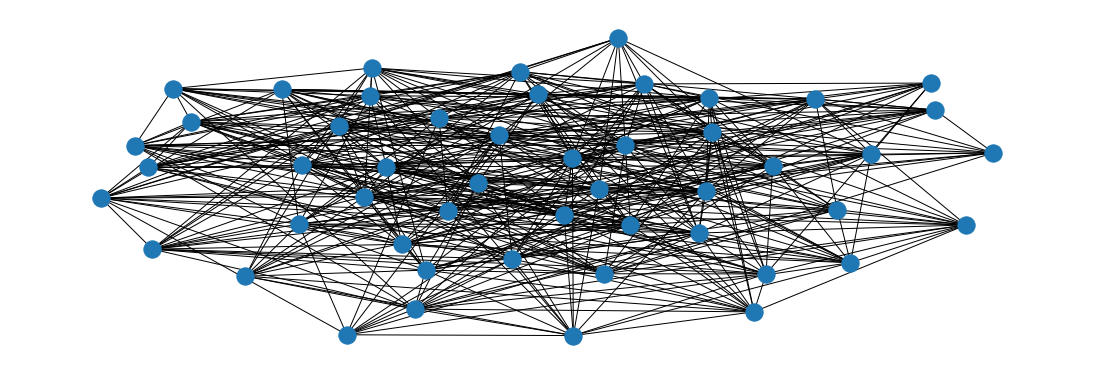

In [118]:
nx.draw(H)
plt.show()

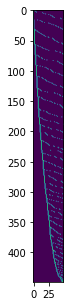

In [119]:
#Get incidence matrix
B = nx.linalg.graphmatrix.incidence_matrix(H)
B = sp.sparse.csr_matrix.todense(B).transpose()
plt.imshow(B)

In [ ]:
#def blockRK_path(A, G, sol, b, N, c, l):


## Testing

In [127]:
# Path Block RK For a General Graph
N = 100
path, text_x, x_list, errors = blockRK_path(A, G, sol, b, N, x, 20)

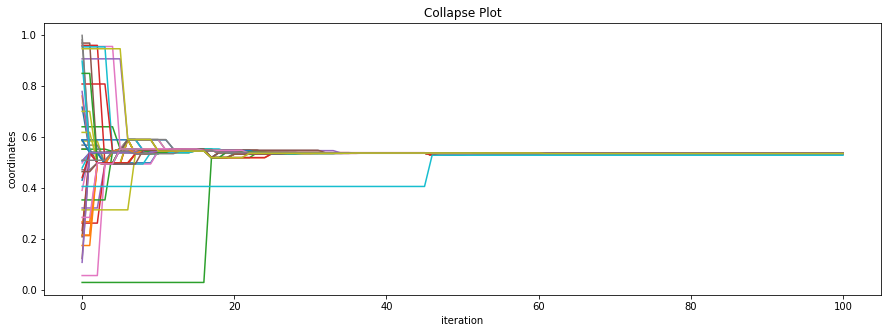

In [128]:
collapse_plt_test(x_list, n, N, xbar)
plt.title('Collapse Plot')
plt.xlabel('iteration', fontsize=10)
plt.ylabel('coordinates', fontsize=10)
grph = plt.gcf()
plt.show()
grph.savefig('gen_path_cp.png')

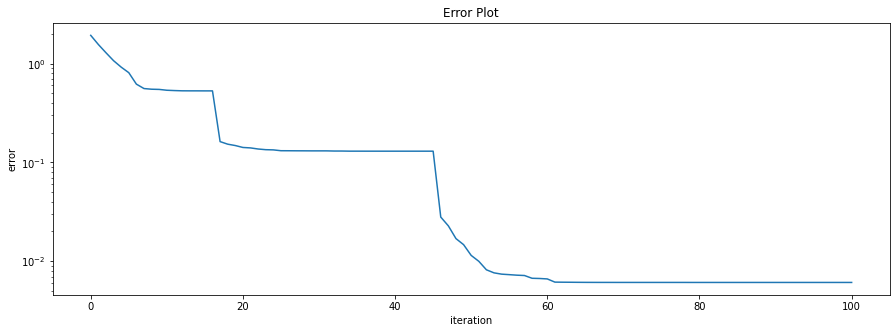

In [129]:
# def error_plt(errors, G, blks, sol, rate='arbi'):
error_plt(errors, G, path, sol, rate='path')
plt.title('Error Plot')
plt.xlabel('iteration', fontsize=10)
plt.ylabel('error', fontsize=10)
plt.savefig('gen_path_ep.png')

list

([], (355, 4))

# Debugging Corner
Where bad code goes to die

In [ ]:
def blocks_from_cliques_test(G, A):
    cliques = list(enumerate_all_cliques(G))
    blks = blocks_pnts(A, cliques)
    return blks

In [ ]:
# Grab Cliques
def convert(subgraphs):
    prod = []
    for subgraph in subgraphs:
        prod.append(edges_from_pnts(subgraph))
    return prod

In [ ]:
def overlap(x, target):
    x_set = set(x)
    target_set = set(target)
    intersection = target_set.intersection(x_set)
    if len(intersection) > 0:
        return True
    else:
        return False

In [28]:
index = []
for j in range(20):
    if overlap(cliques[j], cliques[20]):
        index.append(j)

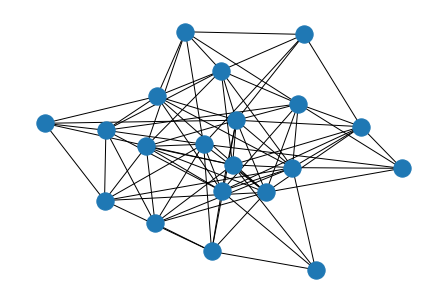

In [29]:
def clique_cover_v1(cliques):
    # No knowledge of G is needed given enumerate_all_cliques returns ALL edges in G
    cliques = convert(cliques)
    n = len(cliques)
    i = n-1
    m = 1
    remove_index = []
    while i > 1:
        test = cliques[i]
        for j in range(i):
            if overlap(cliques[j], cliques[i]):
                remove_index.append(j)
        for k in remove_index:
            print(test, cliques[k])
            cliques.remove(cliques[k])
        n = len(cliques)
        if remove_index != []:
            i = n - (m+1)
        else:
            i = i - 1
        remove_index = []
        m = m + 1
    return cliques

array([[0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869],
       [0.53575869]])

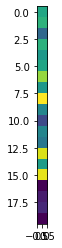

In [30]:
# Fix x, b
# Secret initial vector x
x = np.random.rand(e,1)
plt.imshow(x)
# Zero Vector b
b = np.zeros((g,1))

xbar = np.mean(x)
# Create solution vector (vector with just xbar as values)
sol = np.full((e,1), xbar)
sol

In [ ]:
D

In [ ]:
test = path_blk(X, B, 0, 7) # something is wrong with find_subgraph_from_pnts

In [ ]:
test

In [77]:
def rRtest(blks):
    #Counter(it.chain.from_iterable(map(set, blks))
# OR 
    counts = Counter(x for xs in blks for x in set(xs))
    R = counts.most_common()[0]
    r = counts.most_common()[-1]
    return r, R

In [79]:
rR(path)

(1, 4)

(123, 1)

In [ ]:
paths, test_x, x_list, errors = blockRK_path(X, B, sol, b, 100, x, 3)

In [ ]:
collapse_plt_test(x_list, 20, 99, xbar)

In [ ]:
collapse_plt(x_list, 20, 100, sol)